# 070. Random Forest / Gradient Boosting - Titanic

- Titanic 호의 생존 예측

Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)  $\rightarrow$ 객실 등급  
survival -  Survival (0 = 사망; 1 = 생존)  $\rightarrow$ 생존여부  
name - Name  
sex - Sex  
age - Age  
sibsp - Number of Siblings/Spouses Aboard  $\rightarrow$ 함께 탑승한 형제 또는 배우자 수   
parch - Number of Parents/Children Aboard  $\rightarrow$ 함께 탑승한 부모 또는 자녀 수  
ticket - Ticket Number  
fare - Passenger Fare (British pound)  
cabin - Cabin  $\rightarrow$ 선실번호  
embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)  $\rightarrow$ 탑승한 항구(얼마나 부유한지와 관련)

# 1. EDA(Explanatory Data Analysis)

- 어떤 문제를 해결하려고 하는가 ?
- 어떤 종류의 Data를 가지고 있고, 이것을 어떻게 처리해야 하는가 ?
- Data의 결측치(missing value)가 무었이고 이것을 어떻게 처리해야 하는가 ?
- 이상치(outlier)는 어떤 것이 있으며, 이것을 어떻게 처리해야 하는가?
- 모델의 정확도를 높이기 위해 어떻게 새로운 feature를 만들까 ?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import seaborn as sns

df = pd.read_csv("datasets/titanic.csv")

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

## Data 의 type 과 missing value 처리

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [7]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

- 891 개의 data 중 177 개를 drop 시키는 것은 너무 많은 양이므로 Age 는 median 으로 채워주고, 
- Embarked 가 null 인 record 는 2 개에 불과 하므로 drop

In [8]:
mean_age = df['Age'].mean()

df['Age'].fillna(mean_age, inplace=True)
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [9]:
df.loc[df.Embarked.isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,female,38.0,0,0,80.0,NaN
829,1,1,female,62.0,0,0,80.0,NaN


In [10]:
df.dropna(inplace=True)
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Data 의 분포 파악

In [63]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.653446,0.524184,0.382452,32.096681
std,0.486260,0.834700,12.968366,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


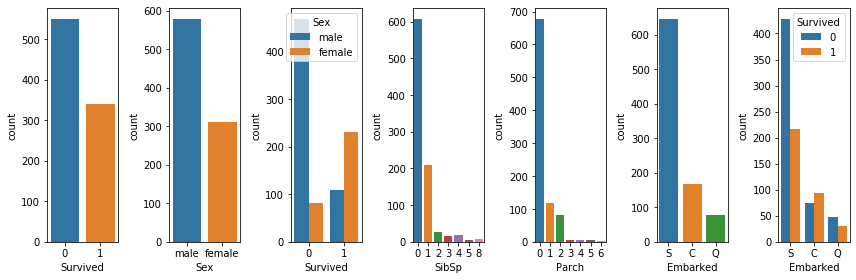

In [68]:
fig, ax = plt.subplots(1, 7, figsize=(12, 4))

sns.countplot(data=df, x='Survived', ax=ax[0])
sns.countplot(data=df, x='Sex', ax=ax[1])
sns.countplot(data=df, x='Survived', hue='Sex', ax=ax[2])
sns.countplot(data=df, x='SibSp', ax=ax[3])
sns.countplot(data=df, x='Parch', ax=ax[4])
sns.countplot(data=df, x='Embarked', ax=ax[5])
sns.countplot(data=df, x='Embarked', hue='Survived', ax=ax[6])
plt.tight_layout()

In [69]:
df[['Survived', 'Sex']].groupby('Sex').sum()

,Survived
Sex,
female,231
male,109


## Categorical Data 의 분포 시각화

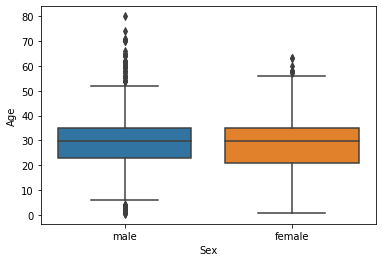

In [70]:
sns.boxplot(data=df, x='Sex', y='Age')

## outlier 시각화

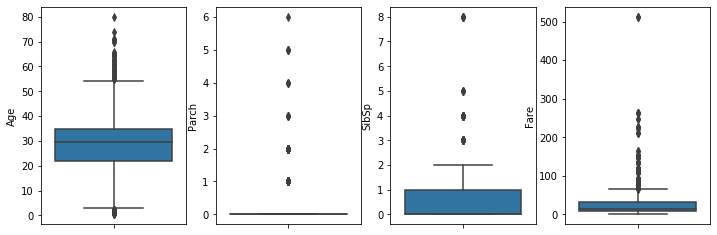

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
sns.boxplot(data=df, y='Age', ax=ax[0])
sns.boxplot(data=df, y='Parch', ax=ax[1])
sns.boxplot(data=df, y='SibSp', ax=ax[2])
sns.boxplot(data=df, y='Fare', ax=ax[3])

## Feature 간의 Correlation Check 

- Target과 correlation이 높은 feature는 중요한 특성값

In [81]:
corr = df.corr()
corr

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.335549,-0.074673,-0.034040,0.083151,0.255290
Pclass,-0.335549,1.000000,-0.327954,0.081656,0.016824,-0.548193
Age,-0.074673,-0.327954,1.000000,-0.231875,-0.178232,0.088604
SibSp,-0.034040,0.081656,-0.231875,1.000000,0.414542,0.160887
Parch,0.083151,0.016824,-0.178232,0.414542,1.000000,0.217532
Fare,0.255290,-0.548193,0.088604,0.160887,0.217532,1.000000


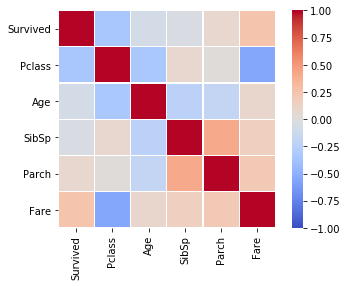

In [93]:
sns.heatmap(corr, square=True, linewidth=0.1, cmap='coolwarm', vmax=1.0, vmin=-1.0)

## Data 의 skewness  check

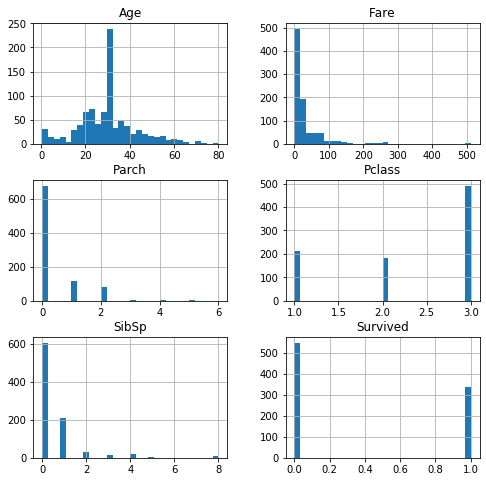

In [95]:
df.hist(bins=30, figsize=(8, 8));

### Fare 의 분포가 심하게 skew 되어 있으므로 log 값으로 바꾸어 skewness 를 완화 시킨다.

In [97]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

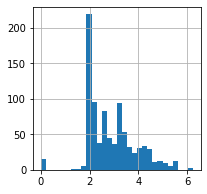

In [98]:
df['Fare'].hist(bins=30, figsize=(3, 3));

## Category 변수 처리

Category column 들을 one-hot-encoding 으로 변환한다.

In [100]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked'])

df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,1.981001,0,1,0,0,1
1,1,1,38.0,1,0,4.266662,1,0,1,0,0
2,1,3,26.0,0,0,2.070022,1,0,0,0,1
3,1,1,35.0,1,0,3.972177,1,0,0,0,1
4,0,3,35.0,0,0,2.085672,0,1,0,0,1


# 2. Machine Learning Model  작성

In [101]:
Y = df['Survived']
X = df.drop(['Survived'], axis=1)

In [102]:
# dataset 을 Training 과 Test set 으로 분리
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [103]:
# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [104]:
# Training set 에 대해 Random Forest Classifier model 을 fitting
classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [105]:
y_pred = classifier.predict(X_test)

print(y_pred)
print()
print("Test set true counts = ", sum(y_test))
print("predicted true counts = ", sum(y_pred))
print("accuracy = {:.2f}".format(sum(y_pred == y_test) / len(y_test)))

[0 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1
 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1
 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1]

Test set true counts =  73
predicted true counts =  62
accuracy = 0.75


## confusion matrix 를 이용한 model 평가

confution matrix
 [[45 28]
 [17 88]]


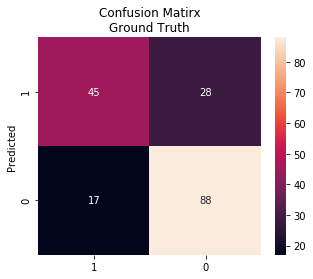

In [106]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns

cm  = confusion_matrix(y_test, y_pred, labels=[1, 0])

print("confution matrix\n", cm)

plt.figure(figsize=(5,4))

ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=[1, 0], yticklabels=[1, 0])
ax.set_ylabel('Predicted')
ax.set_title('Confusion Matirx\nGround Truth')
None

In [107]:
print("f1 score : ", f1_score(y_test, y_pred, labels=[1, 0]))

f1 score :  0.6666666666666667


## Gradient Boosting

In [108]:
from sklearn.ensemble import GradientBoostingClassifier

gbclassifier = GradientBoostingClassifier(learning_rate=0.1, n_estimators=10, max_depth=5)
gbclassifier.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [109]:
y_pred = gbclassifier.predict(X_test)

In [110]:
accuracy_score(y_test, y_pred)

0.7471910112359551

# 실습문제 - mnist 손글씨 인식 with RandomForest

In [114]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784')
#mnist.data.shape, mnist.target.shape
mnist = {}
df = pd.read_csv("../mnist.csv", index_col=0)
mnist["data"] = df.iloc[:,:-1].values
mnist["target"] = df.iloc[:, -1].values
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array([5, 0, 4, ..., 4, 5, 6])}

In [115]:
mnist["data"].shape, mnist["target"].shape

((70000, 784), (70000,))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"], test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56000, 784), (14000, 784), (56000,), (14000,))

In [117]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

prediction = clf.predict(X_test)
print(prediction.shape)

# accuracy
result = (prediction == y_test).mean()
print(result)

(14000,)
0.9667142857142857


In [118]:
incorrect_indices = np.nonzero(prediction != y_test)[0]

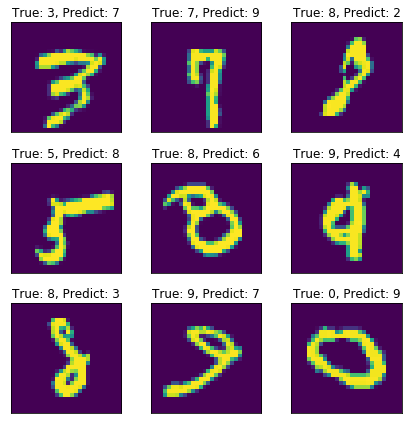

In [119]:
plt.figure(figsize=(6, 6))
for i, index in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[index].reshape(28, 28))
    plt.title(f"True: {y_test[index]}, Predict: {prediction[index]}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

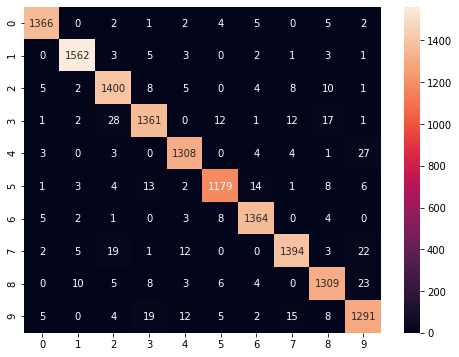

In [120]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import  accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
import seaborn as sns

cm  = confusion_matrix(y_test, prediction)

plt.figure(figsize=(8, 6))

ax = sns.heatmap(cm, annot=True, fmt='d')
None